# (1) Connecting Google Colab to Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd

/root


In [3]:
%cd '/content/drive'
%pwd

/content/drive


'/content/drive'

In [4]:
%ls

MyDrive/  Shareddrives/


In [5]:
%cd 'MyDrive/'

/content/drive/MyDrive


In [6]:
%pwd

'/content/drive/MyDrive'

In [7]:
%cd 'Colab_Data'

/content/drive/MyDrive/Colab_Data


In [ ]:
%pwd

'/content/drive/My Drive/Colab_Data/FOMC_04_pickle_data'

# (2) Word Enbeddings

## Implementing a word2vec model using a CBOW (Continuous Bag of Words) neural network architecture

In [ ]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
%pwd

'/content/drive/MyDrive/Colab_Data'

In [ ]:
import os
os.chdir(r'FOMC_04_pickle_data')
os.getcwd()

'/content/drive/My Drive/Colab_Data/FOMC_04_pickle_data'

In [ ]:
os.getcwd()

'/content/drive/My Drive/Colab_Data/FOMC_04_pickle_data'

In [ ]:
!pip3 install pickle5
import pickle5 as pickle

     |████████████████████████████████| 133kB 6.4MB/s 
  Created wheel for pickle5: filename=pickle5-0.0.11-cp36-cp36m-linux_x86_64.whl size=218605 sha256=6c9aa11e08372241d545a14354ff3a62d684fcc52239feff995cc331e5a9dc3f
  Stored in directory: /root/.cache/pip/wheels/a6/90/95/f889ca4aa8b0e0c7f21c8470b6f5d6032f0390a3a141a9a3bd
Successfully built pickle5


In [ ]:
# import pickle

FOMC_pickle = [0] * 222 # list(range(0,222))
FOMC_pickle_2 = [0] * 222

for i in range(0,222):
    name = str(i+1)+'.txt'    
    FOMC_pickle[i] = pickle.load(open(name, 'rb'))
    FOMC_pickle_2[i] = ' '.join(FOMC_pickle[i])

In [ ]:
import pandas as pd
# df = pd.read_excel (r'Path where the Excel file is stored\File name.xlsx')
df = pd.read_excel(r'FOMC_02_excel_data/Fed_fund_rate_change.xlsx')

fund_rate_change = list(df.iloc[:,5])
fund_rate_change_date = list(df.iloc[:,1])

In [ ]:
corpus_df = pd.DataFrame({'Document': FOMC_pickle_2, 
                          'Category': fund_rate_change[24:246]})
corpus_df = corpus_df[['Document', 'Category']]
print(corpus_df.head())

                                            Document  Category
0  inform review meet indic econom activ rose app...         0
1  inform review meet suggest econom activ expand...         0
2  inform review meet suggest pace econom expans ...         0
3  inform review meet provid mix read economi bal...         0
4  inform review committe suggest econom activ ex...         0


In [ ]:
from keras.preprocessing import text
from keras.utils import np_utils
from keras.preprocessing import sequence

tokenizer = text.Tokenizer()
tokenizer.fit_on_texts(FOMC_pickle_2)
word2id = tokenizer.word_index

word2id['PAD'] = 0
id2word = {v:k for k, v in word2id.items()}
wids = [[word2id[w] for w in text.text_to_word_sequence(doc)] for doc in FOMC_pickle_2]

vocab_size = len(word2id)
embed_size = 100
window_size = 2

print('Vocabulary Size:', vocab_size)
print('Vocabulary Sample:', list(word2id.items())[:10])

Vocabulary Size: 4103
Vocabulary Sample: [('rate', 1), ('inflat', 2), ('price', 3), ('market', 4), ('econom', 5), ('increas', 6), ('growth', 7), ('continu', 8), ('quarter', 9), ('committe', 10)]


### Build (context_words, target_word) pair generator

In [ ]:
def generate_context_word_pairs(corpus, window_size, vocab_size):
    context_length = window_size*2
    for words in corpus:
        sentence_length = len(words)
        for index, word in enumerate(words):
            context_words = []
            label_word   = []            
            start = index - window_size
            end = index + window_size + 1
            
            context_words.append([words[i] 
                                 for i in range(start, end) 
                                 if 0 <= i < sentence_length 
                                 and i != index])
            label_word.append(word)

            x = sequence.pad_sequences(context_words, maxlen=context_length)
            y = np_utils.to_categorical(label_word, vocab_size)
            yield (x, y)

In [ ]:
import numpy as np

i = 0
for x, y in generate_context_word_pairs(corpus=wids, window_size=window_size, vocab_size=vocab_size):
    if 0 not in x[0]:
        print('Context (X):', [id2word[w] for w in x[0]], '-> Target (Y):', id2word[np.argwhere(y[0])[0][0]])
    
        if i == 10:
            break
        i += 1

Context (X): ['inform', 'review', 'indic', 'econom'] -> Target (Y): meet
Context (X): ['review', 'meet', 'econom', 'activ'] -> Target (Y): indic
Context (X): ['meet', 'indic', 'activ', 'rose'] -> Target (Y): econom
Context (X): ['indic', 'econom', 'rose', 'appreci'] -> Target (Y): activ
Context (X): ['econom', 'activ', 'appreci', 'fourth'] -> Target (Y): rose
Context (X): ['activ', 'rose', 'fourth', 'quarter'] -> Target (Y): appreci
Context (X): ['rose', 'appreci', 'quarter', 'final'] -> Target (Y): fourth
Context (X): ['appreci', 'fourth', 'final', 'demand'] -> Target (Y): quarter
Context (X): ['fourth', 'quarter', 'demand', 'buoy'] -> Target (Y): final
Context (X): ['quarter', 'final', 'buoy', 'strength'] -> Target (Y): demand
Context (X): ['final', 'demand', 'strength', 'consumpt'] -> Target (Y): buoy


### Build CBOW Deep Network Model

In [ ]:
import keras.backend as K
from keras.models import Sequential
from keras.layers import Dense, Embedding, Lambda

cbow = Sequential()
cbow.add(Embedding(input_dim=vocab_size, output_dim=embed_size, input_length=window_size*2))
cbow.add(Lambda(lambda x: K.mean(x, axis=1), output_shape=(embed_size,)))
cbow.add(Dense(vocab_size, activation='softmax'))

cbow.compile(loss='categorical_crossentropy', optimizer='rmsprop')
print(cbow.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 4, 100)            410300    
_________________________________________________________________
lambda (Lambda)              (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 4103)              414403    
Total params: 824,703
Trainable params: 824,703
Non-trainable params: 0
_________________________________________________________________
None


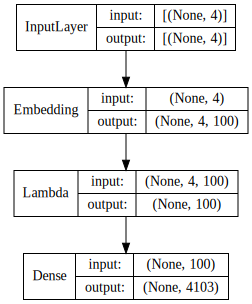

In [ ]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(cbow, show_shapes=True, show_layer_names=False, 
                 rankdir='TB', dpi=72).create(prog='dot', format='svg'))

### Train model for 5 epochs

In [ ]:
for epoch in range(1, 2): # origin: range(1, 6)
    loss = 0.
    i = 0
    for x, y in generate_context_word_pairs(corpus=wids, window_size=window_size, vocab_size=vocab_size):
        i += 1
        loss += cbow.train_on_batch(x, y)
        if i % 5000 == 0: # origin: 100000
            print('Processed {} (context, word) pairs'.format(i))

    print('Epoch:', epoch, '\tLoss:', loss)
    print()

Processed 5000 (context, word) pairs
Processed 10000 (context, word) pairs
Processed 15000 (context, word) pairs
Processed 20000 (context, word) pairs
Processed 25000 (context, word) pairs
Processed 30000 (context, word) pairs
Processed 35000 (context, word) pairs
Processed 40000 (context, word) pairs
Processed 45000 (context, word) pairs
Processed 50000 (context, word) pairs
Processed 55000 (context, word) pairs
Processed 60000 (context, word) pairs
Processed 65000 (context, word) pairs
Processed 70000 (context, word) pairs
Processed 75000 (context, word) pairs
Processed 80000 (context, word) pairs
Processed 85000 (context, word) pairs
Processed 90000 (context, word) pairs
Processed 95000 (context, word) pairs
Processed 100000 (context, word) pairs
Processed 105000 (context, word) pairs
Processed 110000 (context, word) pairs
Processed 115000 (context, word) pairs
Processed 120000 (context, word) pairs
Processed 125000 (context, word) pairs
Processed 130000 (context, word) pairs
Proces

### Get word embeddings

In [ ]:
# Display all columns 
pd.set_option('display.max_columns', None)
# Display all rows
pd.set_option('display.max_rows', None)

# pd.options.display.max_colwidth = 200

In [ ]:
import pandas as pd

weights = cbow.get_weights()[0]
weights = weights[1:]
print(weights.shape)

pd.DataFrame(weights, index=list(id2word.values())[1:]).head(n=100)

(4102, 100)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
inflat,-0.565831,-1.084966,-1.142203,0.709716,0.569631,-0.598660,-1.007157,0.547390,-0.611694,0.851210,0.846652,-0.714103,0.991642,0.897811,0.963090,-0.829542,0.990913,1.100232,-0.989242,-0.704292,-0.650730,1.197081,-0.543470,-1.213083,-0.342534,0.936560,-0.885257,1.054789,0.745113,0.838576,0.647811,-1.046049,0.948512,0.804776,-1.003605,-1.029115,1.155692,-1.014267,0.672950,-1.356915,0.810909,-0.925498,-0.784454,1.644810,-0.756223,-0.981478,0.506496,0.695015,0.865461,-0.631830,-0.521165,0.774803,1.159772,-0.112303,0.745447,1.095930,0.770047,0.730860,0.960829,1.043627,1.071819,-0.710525,1.222603,0.963273,0.687348,-1.269773,-0.584582,0.724986,0.921622,0.510480,-1.144902,-0.965310,0.754534,-1.306929,-0.944018,1.323757,-0.913291,1.062146,-0.828933,0.854640,0.826618,0.938922,0.508288,1.354995,0.782334,-0.531034,1.100928,-0.776917,-1.181474,-0.457499,0.672781,-0.568836,-0.704923,-0.925158,0.833404,0.880884,-0.706385,-0.633121,0.688047,-0.638687
price,-0.421302,-0.849625,-0.744595,0.895730,0.027051,-0.130491,-0.558551,0.954578,-0.641916,0.726625,0.283037,-0.629112,0.939657,0.568291,1.112961,-0.728622,0.937255,0.744732,-0.903329,-0.906913,-0.692190,1.124433,-0.578424,-0.695226,-0.529376,0.547457,-0.823384,1.356006,0.622715,0.935089,0.800543,-0.967602,0.366390,0.836177,-0.406160,-0.804870,0.664404,-0.939201,0.824251,-0.981174,0.557565,-0.817658,-0.682358,0.768664,-0.784645,-0.804469,0.605650,0.840130,0.912644,-0.520282,-0.545593,0.921066,0.697135,-0.498099,0.726285,0.761699,1.202695,0.714451,0.627160,1.163343,0.881140,-0.784351,0.236331,1.214912,0.620937,-0.161177,-0.568742,1.221004,0.620058,1.143451,-0.504322,-1.069267,0.804684,-0.507110,-0.431252,0.966518,-0.525017,1.018225,-0.661651,0.573466,0.361568,0.418146,1.359758,0.660906,1.362972,-0.609305,0.647336,-0.833147,-0.888480,-1.056771,0.839179,-0.511882,-0.326762,-0.442788,0.826854,0.686894,-1.003528,-0.875362,0.486527,-0.784708
market,-0.581059,-0.909592,-0.847371,0.405949,0.864141,-0.888526,-0.323014,0.614079,-0.878982,1.132179,0.748068,-0.976288,0.543726,0.979169,0.903274,-1.169995,0.782516,0.878397,-0.720004,-1.458501,-0.861668,1.279083,-1.088843,-0.732252,-0.806249,1.081389,-0.690161,0.949012,0.814123,0.641292,0.873090,-0.943895,1.356089,1.068116,-0.723747,-0.813525,1.083559,-0.400515,0.832824,-0.732115,1.183642,-0.872549,-0.461761,0.773144,-0.576403,-1.021809,0.975095,0.962638,0.542747,-0.452223,-0.464862,0.944303,0.928476,-0.505155,0.470425,1.254898,0.519753,1.016698,1.149535,0.724216,1.022732,-0.826590,0.665015,1.049488,0.860535,-0.603409,-0.744707,0.455161,0.742542,0.847875,-0.904141,-0.730120,0.767136,-1.003795,-1.099774,0.683743,-0.456039,0.856654,-1.073895,0.655255,1.214393,0.615740,1.074250,0.939253,0.724853,-0.834972,0.589813,-0.940444,-0.621355,-0.677986,0.940893,-0.861178,-0.758581,-1.267583,0.972407,0.714243,-0.842993,-0.820002,0.773627,-0.647338
econom,-0.931372,-0.769237,-1.111422,0.514900,0.665665,-0.242115,-0.932581,1.165619,-0.667515,0.856819,0.720742,-0.807430,1.144576,0.620396,1.143442,-0.968365,0.960575,1.083743,-0.807676,-1.187243,-0.986672,1.247116,-0.307938,-1.095720,-0.584411,1.204293,-1.299995,1.079308,0.907711,1.004001,1.192984,-1.224290,1.173551,0.952665,-0.726585,-0.689051,0.763177,-1.223657,0.775022,-1.147209,0.667571,-0.800657,-0.979354,0.760166,-1.394330,-1.180591,0.534552,0.503664,0.984401,-1.042141,-0.520208,0.916010,0.893832,-0.746796,0.982621,0.905137,1.489954,0.914994,1.407406,1.246910,1.063767,-0.816064,0.506765,0.801112,0.978796,-0.523744,-1.124291,0.940437,1.347129,0.797954,-1.066854,-1.239459,1.053523,-0.936778,-1.131581,1.006493,-0.682344,0.593009,-0.943086,0.879433,0.987955,0.418109,1.088573,1.207232,0.967778,-1.261098,1.059748,-1.127234,-0.975683,-0.9

### Build a distance matrix to view the most similar words (contextually)

In [ ]:
from sklearn.metrics.pairwise import euclidean_distances

distance_matrix = euclidean_distances(weights)
print(distance_matrix.shape)

similar_words = {search_term: [id2word[idx] for idx in distance_matrix[word2id[search_term]-1].argsort()[1:6]+1] 
                   for search_term in ['inflat', 'price', 'market', 'econom', 'increas', 'growth', 'continu','quarter', 'expect', 'remain', 'polici', 
                                       'consum', 'condit', 'busi', 'feder', 'term', 'level', 'spend', 'activ', 'labor', 'financi', 'indic',
                                       'pace', 'percent', 'meet', 'economi' ,'product', 'outlook', 'risk', 'fund']}

similar_words

(4102, 4102)


{'activ': ['rel', 'notabl', 'respons', 'april', 'septemb'],
 'busi': ['firm', 'report', 'could', 'continu', 'level'],
 'condit': ['less', 'volatil', 'tax', 'still', 'particularli'],
 'consum': ['household', 'lower', 'higher', 'number', 'result'],
 'continu': ['could', 'also', 'effect', 'increas', 'level'],
 'econom': ['suggest', 'economi', 'demand', 'continu', 'howev'],
 'economi': ['effect', 'might', 'could', 'addit', 'continu'],
 'expect': ['also', 'liquid', 'number', 'well', 'current'],
 'feder': ['effect', 'could', 'larg', 'would', 'loan'],
 'financi': ['might', 'also', 'continu', 'howev', 'substanti'],
 'fund': ['appar', 'much', 'notabl', 'seem', 'weather'],
 'growth': ['sever', 'addit', 'may', 'also', 'larg'],
 'increas': ['declin', 'continu', 'could', 'effect', 'rose'],
 'indic': ['addit', 'also', 'might', 'firm', 'howev'],
 'inflat': ['relat', 'addit', 'sever', 'forward', 'result'],
 'labor': ['accommod', 'although', 'number', 'respons', 'septemb'],
 'level': ['effect', 'could'

### Visualize word embeddings

In [ ]:
from sklearn.manifold import TSNE

words = sum([[k] + v for k, v in similar_words.items()], [])
wvs = w2v_model.wv[words]

tsne = TSNE(n_components=2, random_state=0, n_iter=10000, perplexity=2)
np.set_printoptions(suppress=True)
T = tsne.fit_transform(wvs)
labels = words

plt.figure(figsize=(14, 8))
plt.scatter(T[:, 0], T[:, 1], c='orange', edgecolors='r')
for label, x, y in zip(labels, T[:, 0], T[:, 1]):
    plt.annotate(label, xy=(x+1, y+1), xytext=(0, 0), textcoords='offset points')

NameError: ignored

## Implementing a word2vec model using a skip-gram neural network architecture

### Build Vocabulary

In [ ]:
from keras.preprocessing import text

tokenizer = text.Tokenizer()
tokenizer.fit_on_texts(FOMC_pickle_2)

word2id = tokenizer.word_index
id2word = {v:k for k, v in word2id.items()}

vocab_size = len(word2id) + 1 
embed_size = 100

wids = [[word2id[w] for w in text.text_to_word_sequence(doc)] for doc in FOMC_pickle_2]
print('Vocabulary Size:', vocab_size)
print('Vocabulary Sample:', list(word2id.items())[:10])

Vocabulary Size: 4103
Vocabulary Sample: [('rate', 1), ('inflat', 2), ('price', 3), ('market', 4), ('econom', 5), ('increas', 6), ('growth', 7), ('continu', 8), ('quarter', 9), ('committe', 10)]


### Build and View sample skip grams ((word1, word2) -> relevancy)

In [ ]:
from keras.preprocessing.sequence import skipgrams

# generate skip-grams
skip_grams = [skipgrams(wid, vocabulary_size=vocab_size, window_size=10) for wid in wids]

# view sample skip-grams
pairs, labels = skip_grams[0][0], skip_grams[0][1]
for i in range(10):
    print("({:s} ({:d}), {:s} ({:d})) -> {:d}".format(
          id2word[pairs[i][0]], pairs[i][0], 
          id2word[pairs[i][1]], pairs[i][1], 
          labels[i]))

(though (207), year (12)) -> 1
(surround (751), cute (3725)) -> 0
(year (12), continu (8)) -> 1
(expand (140), somewhat (50)) -> 1
(balanc (52), rational (2047)) -> 0
(anticip (93), homebuy (1091)) -> 0
(interest (149), implic (516)) -> 1
(restrain (381), infect (2870)) -> 0
(though (207), two (290)) -> 1
(consist (134), mae (1893)) -> 0


### Build Skip-gram Deep Network Model

In [ ]:
from keras.layers import Dot
from keras.layers.core import Dense, Reshape
from keras.layers.embeddings import Embedding
from keras.models import Sequential
from keras.models import Model

word_model = Sequential()
word_model.add(Embedding(vocab_size, embed_size,
                         embeddings_initializer="glorot_uniform",
                         input_length=1))
word_model.add(Reshape((embed_size, )))

context_model = Sequential()
context_model.add(Embedding(vocab_size, embed_size,
                  embeddings_initializer="glorot_uniform",
                  input_length=1))
context_model.add(Reshape((embed_size,)))

model_arch = Dot(axes=1)([word_model.output, context_model.output])
model_arch = Dense(1, kernel_initializer="glorot_uniform", activation="sigmoid")(model_arch)
model = Model([word_model.input,context_model.input], model_arch)
#model.add(Merge([word_model, context_model], mode="dot"))
#model.add(Dense(1, kernel_initializer="glorot_uniform", activation="sigmoid"))
model.compile(loss="mean_squared_error", optimizer="rmsprop")
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
embedding_1_input (InputLayer)  [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_2_input (InputLayer)  [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 100)       410300      embedding_1_input[0][0]          
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 1, 100)       410300      embedding_2_input[0][0]          
______________________________________________________________________________________________

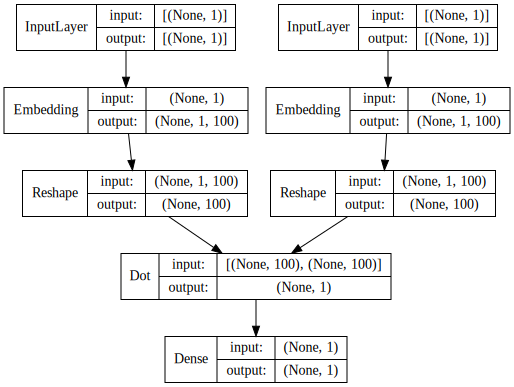

In [ ]:
# %matplotlib inline

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

Image_model = SVG(model_to_dot(model, show_shapes=True, show_layer_names=False, 
                 rankdir='TB', dpi=72).create(prog='dot', format='svg'))
# SVG(model_to_dot(model, show_shapes= True, show_layer_names=True, dpi=65).create(prog='dot', format='svg'))
Image_model

### Train the model for 5 epochs

In [ ]:
for epoch in range(1, 6): # origin: range(1, 6)
    loss = 0
    for i, elem in enumerate(skip_grams):
        pair_first_elem = np.array(list(zip(*elem[0]))[0], dtype='int32')
        pair_second_elem = np.array(list(zip(*elem[0]))[1], dtype='int32')
        labels = np.array(elem[1], dtype='int32')
        X = [pair_first_elem, pair_second_elem]
        Y = labels
        if i % 5000 == 0: # origin: 10000
            print('Processed {} (skip_first, skip_second, relevance) pairs'.format(i))
        loss += model.train_on_batch(X,Y)  

    print('Epoch:', epoch, 'Loss:', loss)

Processed 0 (skip_first, skip_second, relevance) pairs
Epoch: 1 Loss: 25.172159664332867
Processed 0 (skip_first, skip_second, relevance) pairs
Epoch: 2 Loss: 22.93758349120617
Processed 0 (skip_first, skip_second, relevance) pairs
Epoch: 3 Loss: 22.639260448515415
Processed 0 (skip_first, skip_second, relevance) pairs
Epoch: 4 Loss: 22.374635584652424
Processed 0 (skip_first, skip_second, relevance) pairs
Epoch: 5 Loss: 22.056938849389553


### Get word embeddings

In [ ]:
word_embed_layer = model.layers[2]
weights = word_embed_layer.get_weights()[0][1:]

print(weights.shape)
pd.DataFrame(weights, index=id2word.values()).head(n=100)

(4102, 100)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
rate,-0.179219,-0.255338,0.078591,-0.128489,0.209138,0.180373,-0.088886,0.095470,-0.156643,-0.270424,0.136063,-0.150191,-0.154760,-0.112522,-0.208256,-0.110146,0.151412,0.113649,-0.064607,0.211862,0.191611,0.160505,-0.029170,0.100870,0.018744,0.225183,-0.173857,0.114593,-0.064315,-0.080137,0.131608,-0.097855,0.075686,0.116540,0.162188,-0.096673,0.145928,0.234648,-0.281166,0.227694,0.092568,-0.127669,-0.054940,-0.200001,-0.145730,-0.079556,0.100475,-0.193202,-0.047795,0.136420,-0.013089,-0.084465,0.040684,-0.194653,-0.168776,-0.155066,-0.148367,-0.022266,-0.148607,-0.152995,-0.048341,-0.043395,0.183533,0.145485,-0.229164,0.114147,0.034738,0.055486,-0.014823,0.132889,0.137104,-0.216586,0.183381,-0.122274,0.142238,-0.140069,0.006344,0.105078,0.212957,0.152218,0.138521,-0.022842,-0.101529,0.191346,-0.114157,-0.217012,-0.177516,0.214027,0.173615,0.128983,0.112279,0.043063,0.077039,-0.208190,-0.039264,-0.248618,0.152724,0.022714,0.164107,-0.032325
inflat,-0.175229,-0.175248,0.191286,-0.146538,0.447112,0.299359,-0.097272,0.052461,0.078155,-0.266393,0.304755,0.003129,-0.469736,0.071157,-0.401631,-0.141711,0.014985,-0.017073,-0.171626,0.132744,-0.142383,0.285669,-0.135260,-0.005127,-0.348984,0.452023,0.053873,0.071742,-0.020653,-0.165694,0.112857,-0.163306,0.312977,-0.061101,0.238309,0.003990,0.104831,0.366758,-0.305480,0.377168,0.018148,-0.280727,0.105584,-0.040491,-0.003933,0.061454,0.238117,-0.145875,0.005466,0.464171,0.007906,-0.317668,0.062915,-0.086128,-0.512617,-0.149122,-0.269160,0.072028,-0.267820,-0.558103,0.046590,0.006984,0.074796,-0.053779,-0.041583,-0.043949,0.326505,0.005514,0.181342,0.225298,0.054691,-0.453139,0.239767,-0.287531,-0.139699,-0.116185,0.204000,0.073681,0.238796,0.129208,0.126128,0.152043,-0.213214,0.159565,-0.104564,-0.293845,-0.079227,0.065564,0.060735,0.027051,0.170218,-0.167736,0.476265,-0.379265,-0.268301,-0.387076,0.343562,-0.060384,-0.022824,-0.001113
price,-0.213573,-0.111649,0.173345,-0.286302,0.306333,0.416306,-0.090313,0.159383,-0.016152,0.011738,0.085335,0.032034,-0.458760,0.059992,0.015013,0.300552,0.021105,-0.057947,0.159957,0.257802,-0.233634,0.223068,0.229767,-0.087149,-0.367690,0.271517,-0.083387,0.321196,0.135988,-0.297283,0.105191,-0.333340,0.258708,0.130920,0.260652,-0.082954,0.219629,0.208216,-0.243806,0.367488,0.205566,-0.236965,-0.168380,0.027112,-0.015259,0.055436,0.183774,-0.131449,-0.122741,0.301958,-0.166591,-0.323697,0.279506,-0.226424,-0.045228,-0.203279,-0.014831,0.361652,-0.229250,-0.119147,-0.179702,-0.337650,0.125768,0.112111,-0.193437,0.155429,0.270148,-0.017110,0.247156,0.300139,0.174616,0.119351,0.054316,-0.375962,0.286401,-0.097371,0.227573,0.303029,0.029246,0.140148,0.124822,-0.045303,-0.060381,-0.018191,-0.282948,-0.101088,-0.103082,0.143236,0.101205,0.112550,0.133485,-0.101058,-0.158174,-0.203809,-0.053964,-0.404608,0.224886,-0.097966,-0.070234,0.042702
market,-0.126013,-0.250985,0.124859,-0.048875,0.130491,0.046891,-0.101500,0.140641,-0.228005,-0.144515,0.300443,-0.139962,-0.047134,-0.237367,-0.433987,-0.280995,0.018587,0.075456,-0.215328,0.194886,0.100593,0.099896,-0.091662,-0.061550,-0.256011,0.172079,-0.047378,0.057553,-0.207007,-0.007366,-0.019754,-0.127447,0.074597,0.119730,0.115114,-0.116104,-0.010239,0.236521,-0.225237,0.102774,0.034299,-0.152933,0.048310,-0.219593,-0.182079,-0.129493,0.116041,-0.116895,-0.219377,0.241458,-0.101934,-0.078622,-0.064142,-0.191767,-0.217385,-0.167549,-0.385622,0.073087,-0.172933,-0.242172,-0.154251,-0.020117,0.158592,0.341815,-0.044003,0.031914,0.253043,-0.097335,-0.149912,0.129615,-0.020345,-0.523786,0.103490,-0.140897,0.022227,-0.109844,-0.002941,0.080004,0.139279,0.000439,0.152483,-0.124682,-0.310117,0.106402,0.018438,-0.188043,-0.042931,0.1

### Build a distance matrix to view the most similar words (contextually)

In [ ]:
from sklearn.metrics.pairwise import euclidean_distances

distance_matrix = euclidean_distances(weights)
print(distance_matrix.shape)

similar_words = {search_term: [id2word[idx] for idx in distance_matrix[word2id[search_term]-1].argsort()[1:6]+1] 
                   for search_term in ['inflat', 'price', 'market', 'econom', 'increas', 'growth', 'continu','quarter', 'expect', 'remain', 'polici', 
                                       'consum', 'condit', 'busi']}
                                       # 'feder', 'term', 'level', 'spend', 'activ', 'labor', 'financi', 'indic', 'pace', 'percent', 'meet', 'economi' ,'product', 'outlook', 'risk', 'fund']}

similar_words

(4102, 4102)


{'busi': ['spend', 'outlay', 'invest', 'hous', 'capit'],
 'condit': ['financi', 'maximum', 'stanc', 'decis', 'view'],
 'consum': ['gain', 'person', 'expenditur', 'retail', 'exclud'],
 'continu': ['though', 'district', 'weaken', 'mix', 'fundament'],
 'econom': ['outlook', 'assess', 'develop', 'view', 'current'],
 'expect': ['anticip', 'particip', 'current', 'potenti', 'judg'],
 'growth': ['gdp', 'slack', 'strengthen', 'gradual', 'medium'],
 'increas': ['earlier', 'advanc', 'decreas', 'post', 'record'],
 'inflat': ['expect', 'run', 'particip', 'current', 'project'],
 'market': ['path', 'decis', 'action', 'mandat', 'immedi'],
 'polici': ['committe', 'discuss', 'feder', 'monetari', 'conclus'],
 'price': ['core', 'energi', 'food', 'produc', 'cpi'],
 'quarter': ['rose', 'second', 'industri', 'first', 'vehicl'],
 'remain': ['low', 'elev', 'although', 'subdu', 'despit']}

### Visualize word embeddings

Total words: 84 	Word Embedding shapes: (84, 100)


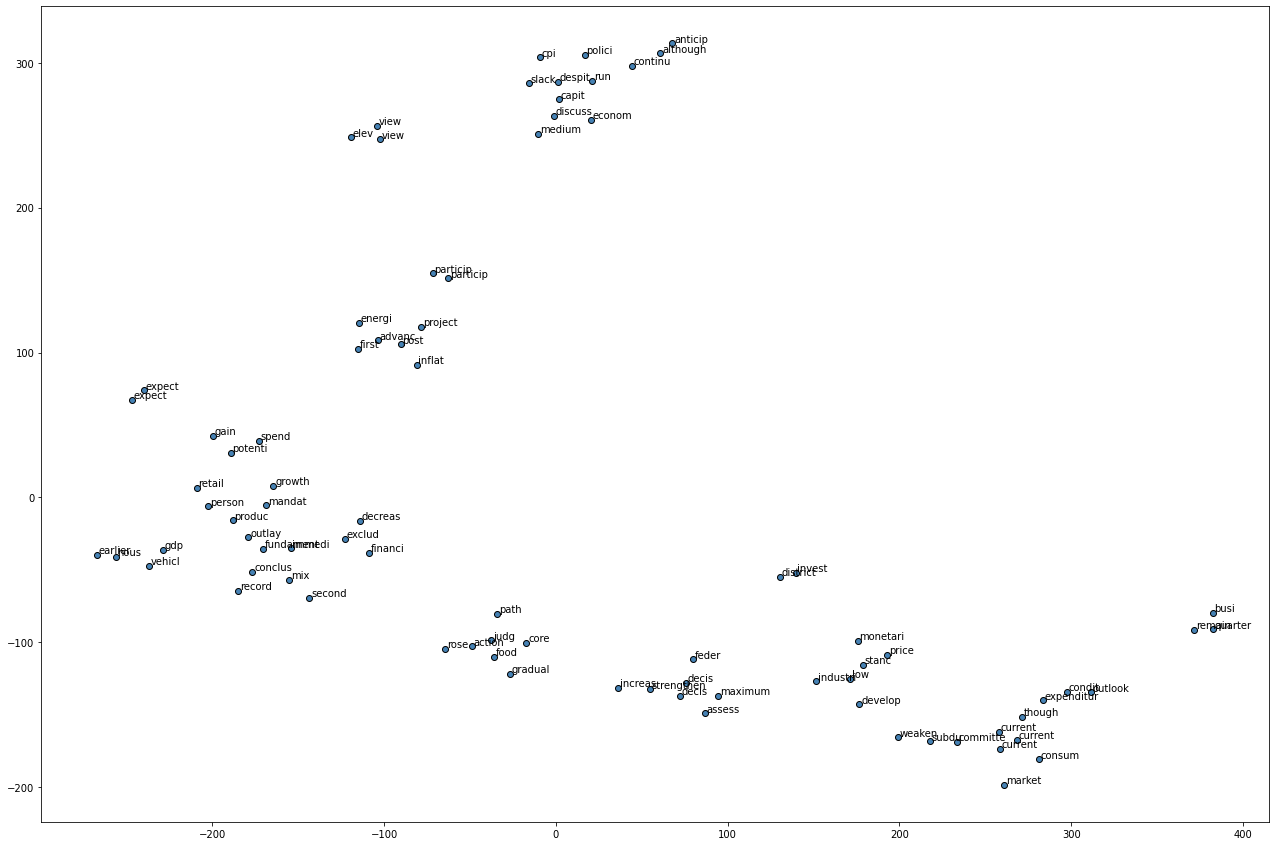

In [ ]:
from sklearn.manifold import TSNE

words = sum([[k] + v for k, v in similar_words.items()], [])
words_ids = [word2id[w] for w in words]
word_vectors = np.array([weights[idx] for idx in words_ids])
print('Total words:', len(words), '\tWord Embedding shapes:', word_vectors.shape)

tsne = TSNE(n_components=2, random_state=0, n_iter=10000, perplexity=3)
np.set_printoptions(suppress=True)
T = tsne.fit_transform(word_vectors)
labels = words

import matplotlib.pyplot as plt

plt.figure(figsize=(22, 15))
plt.scatter(T[:, 0], T[:, 1], c='steelblue', edgecolors='k')
for label, x, y in zip(labels, T[:, 0], T[:, 1]):
    plt.annotate(label, xy=(x+1, y+1), xytext=(0, 0), textcoords='offset points')

## Leveraging gensim for building a word2vec model

In [ ]:
from gensim.models import word2vec
import nltk

# tokenize sentences in corpus
wpt = nltk.WordPunctTokenizer()
tokenized_corpus = [wpt.tokenize(document) for document in FOMC_pickle_2]

# Set values for various parameters
feature_size = 100    # Word vector dimensionality  
window_context = 30          # Context window size                                                                                    
min_word_count = 1   # Minimum word count                        
sample = 1e-3   # Downsample setting for frequent words

w2v_model = word2vec.Word2Vec(tokenized_corpus, size=feature_size, 
                          window=window_context, min_count=min_word_count,
                          sample=sample, iter=50)

# view similar words based on gensim's model
similar_words = {search_term: [item[0] for item in w2v_model.wv.most_similar([search_term], topn=5)]
                  for search_term in ['inflat', 'price', 'market', 'econom', 'increas', 'growth', 'continu','quarter', 'expect', 'remain', 'polici', 
                                       'consum', 'condit', 'busi']}
similar_words

{'busi': ['autom', 'plant', 'upbeat', 'toric', 'forego'],
 'condit': ['qualiti', 'function', 'gradual', 'sentiment', 'tap'],
 'consum': ['household', 'nondur', 'apparel', 'consumpt', 'store'],
 'continu': ['still', 'remain', 'expediti', 'sult', 'despit'],
 'econom': ['economi', 'reformul', 'await', 'augur', 'acknowledg'],
 'expect': ['anticip', 'core', 'project', 'probabl', 'forecast'],
 'growth': ['expans', 'gain', 'pace', 'recoveri', 'expand'],
 'increas': ['declin', 'rise', 'rose', 'decreas', 'risen'],
 'inflat': ['commod', 'disinflationari', 'core', 'anchor', 'disinfl'],
 'market': ['deepen', 'cantli', 'investor', 'broad', 'surfac'],
 'polici': ['asymmetr', 'deem', 'disadvantag', 'propos', 'advoc'],
 'price': ['headlin', 'food', 'core', 'non', 'inflat'],
 'quarter': ['half', 'row', 'consecut', 'straight', 'anem'],
 'remain': ['stay', 'still', 'continu', 'maintain', 'flation']}

## Visualizing word embeddings

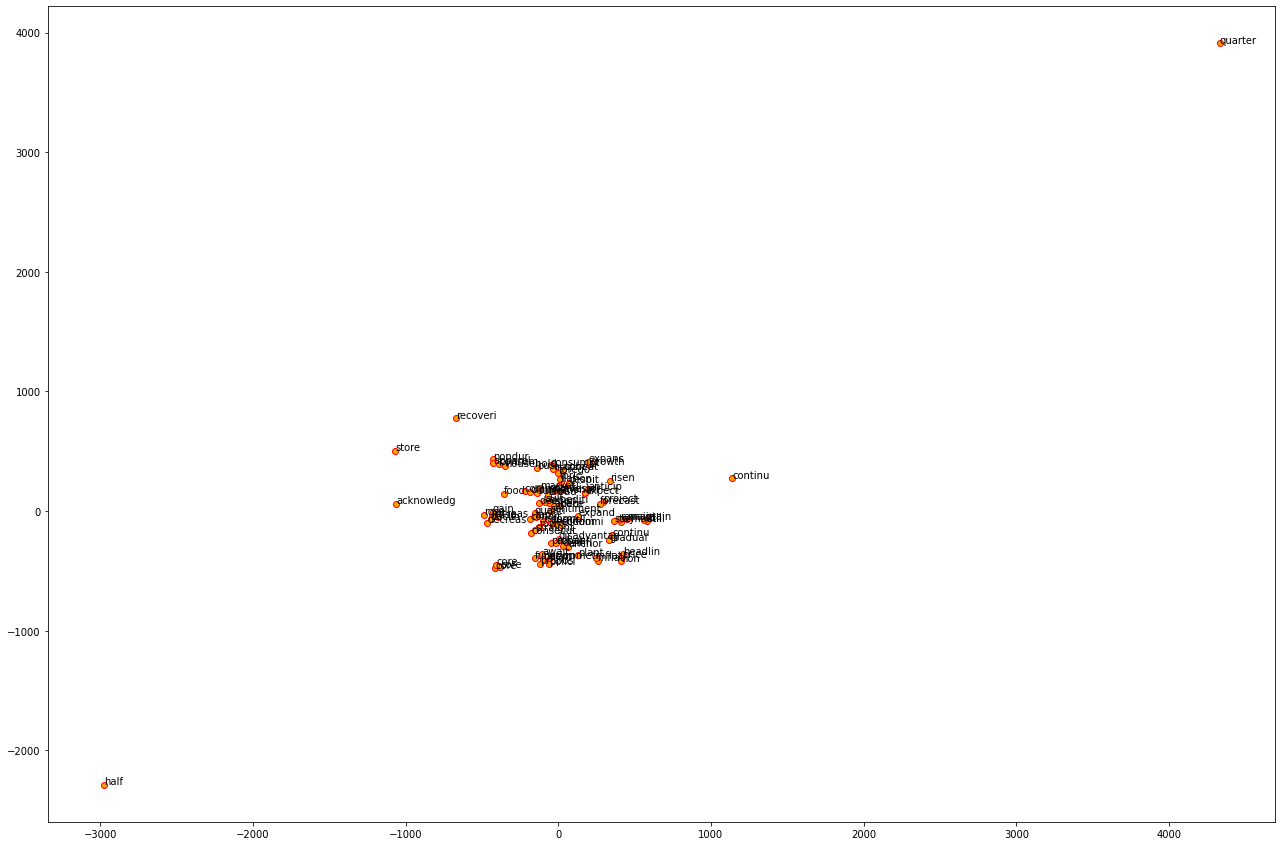

In [ ]:
from sklearn.manifold import TSNE

words = sum([[k] + v for k, v in similar_words.items()], [])
wvs = w2v_model.wv[words]

tsne = TSNE(n_components=2, random_state=0, n_iter=10000, perplexity=2)
np.set_printoptions(suppress=True)
T = tsne.fit_transform(wvs)
labels = words

plt.figure(figsize=(22, 15))
plt.scatter(T[:, 0], T[:, 1], c='orange', edgecolors='r')
for label, x, y in zip(labels, T[:, 0], T[:, 1]):
    plt.annotate(label, xy=(x+1, y+1), xytext=(0, 0), textcoords='offset points')

## Applying the word2vec model on our sample corpus

In [ ]:
wpt = nltk.WordPunctTokenizer()
tokenized_corpus = [wpt.tokenize(document) for document in FOMC_pickle_2]

# Set values for various parameters
feature_size = 10    # Word vector dimensionality  
window_context = 10          # Context window size                                                                                    
min_word_count = 1   # Minimum word count                        
sample = 1e-3   # Downsample setting for frequent words

w2v_model = word2vec.Word2Vec(tokenized_corpus, size=feature_size, 
                              window=window_context, min_count = min_word_count,
                              sample=sample, iter=100)

## Visualize word embeddings

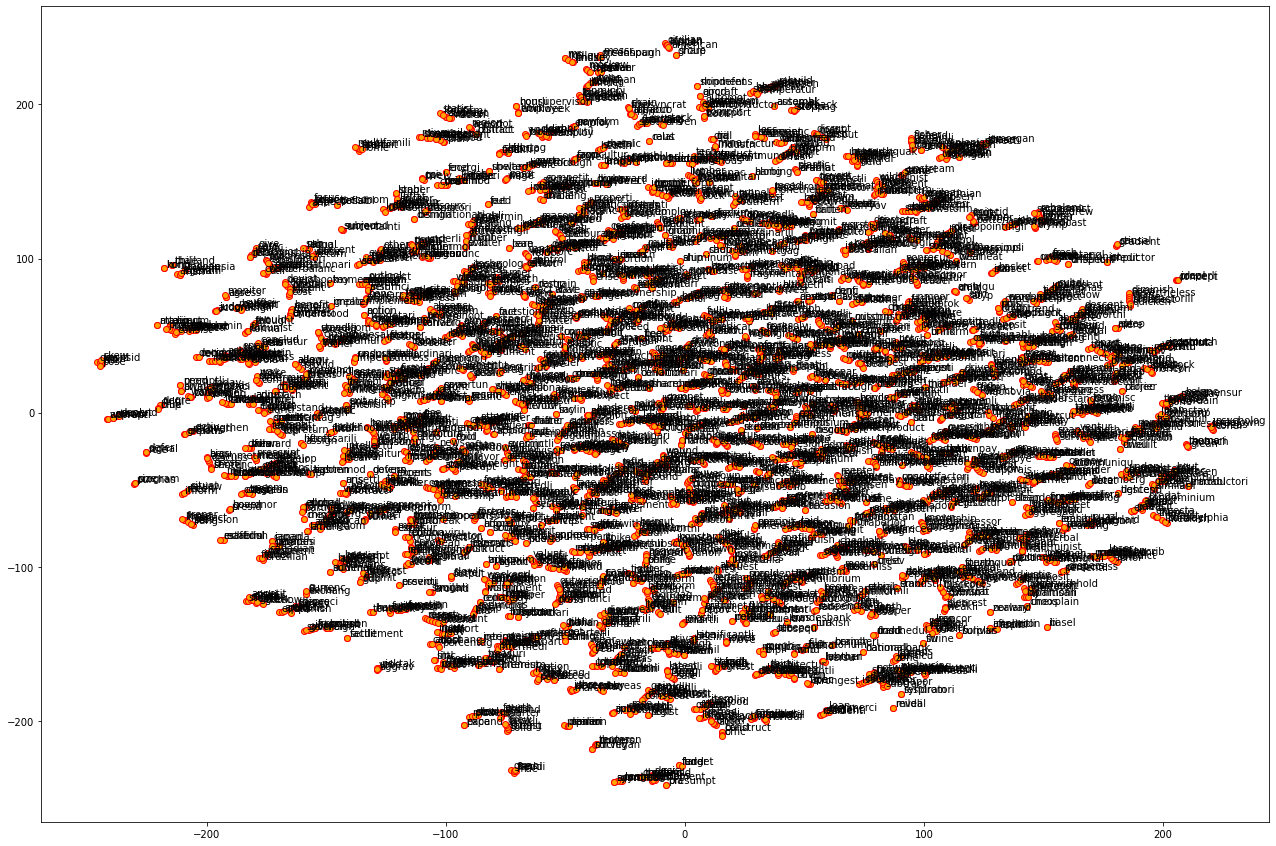

In [ ]:
from sklearn.manifold import TSNE

words = w2v_model.wv.index2word
wvs = w2v_model.wv[words]

tsne = TSNE(n_components=2, random_state=0, n_iter=5000, perplexity=2)
np.set_printoptions(suppress=True)
T = tsne.fit_transform(wvs)
labels = words

plt.figure(figsize=(22,15))
plt.scatter(T[:, 0], T[:, 1], c='orange', edgecolors='r')
for label, x, y in zip(labels, T[:, 0], T[:, 1]):
    plt.annotate(label, xy=(x+1, y+1), xytext=(0, 0), textcoords='offset points')

## Sample word embedding

In [ ]:
w2v_model.wv['increas']

array([-3.4686368 ,  0.33618873,  3.1912603 ,  0.75076306,  0.9021756 ,
        1.7268589 ,  1.8379887 , -2.091352  ,  1.5186515 , -0.8574346 ],
      dtype=float32)

## Build framework for getting document level embeddings

In [ ]:
def average_word_vectors(words, model, vocabulary, num_features):
    
    feature_vector = np.zeros((num_features,),dtype="float64")
    nwords = 0.
    
    for word in words:
        if word in vocabulary: 
            nwords = nwords + 1.
            feature_vector = np.add(feature_vector, model[word])
    
    if nwords:
        feature_vector = np.divide(feature_vector, nwords)
        
    return feature_vector
    
   
def averaged_word_vectorizer(corpus, model, num_features):
    vocabulary = set(model.wv.index2word)
    features = [average_word_vectors(tokenized_sentence, model, vocabulary, num_features)
                    for tokenized_sentence in corpus]
    return np.array(features)

In [ ]:
w2v_feature_array = averaged_word_vectorizer(corpus=tokenized_corpus, model=w2v_model,
                                             num_features=feature_size)
pd.DataFrame(w2v_feature_array)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':


,0,1,2,3,4,5,6,7,8,9
0,-0.073187,0.215224,-0.410983,-0.913800,-0.968867,1.683551,0.646902,-0.645216,-0.176921,-0.846508
1,-0.096194,0.632091,0.184726,-0.136470,-0.945025,1.441544,0.718648,-0.424964,0.512375,-0.684005
2,-0.093803,0.505764,0.205788,0.070207,-0.791781,1.768858,0.813333,-0.565523,0.389235,-0.805665
3,0.083038,0.299103,-0.380289,-0.880351,-0.944279,2.275214,0.474597,-0.471064,-0.541231,-1.136795
4,-0.481334,0.398431,0.214284,-0.031313,-0.986912,1.655842,0.860441,-0.563855,0.075591,-0.761825
5,-0.420778,0.409027,0.152956,-0.016301,-1.022202,1.546982,0.875652,-0.615125,0.321572,-0.817107
6,-1.048513,-1.362399,-0.359312,-0.302599,-2.376912,3.794679,-0.094611,-1.451467,-2.599829,-2.982883
7,-0.145525,0.486228,-0.013463,-0.228653,-1.116311,1.844217,0.948932,-0.435193,0.543927,-0.851665
8,0.318059,0.420565,-0.270957,-0.686091,-1.254866,2.014159,0.493498,-0.689764,0.031401,-0.892628
9,0.249317,0.309593,-0.053721,-0.153132,-0.963805,1.735580,0.775477,-0.451076,0.776770,-0.900613


## Clustering with word embeddings

In [ ]:
from sklearn.cluster import AffinityPropagation

ap = AffinityPropagation()
ap.fit(w2v_feature_array)
cluster_labels = ap.labels_
cluster_labels = pd.DataFrame(cluster_labels, columns=['ClusterLabel'])
pd.concat([corpus_df, cluster_labels], axis=1)

,Document,Category,ClusterLabel
0,inform review meet indic econom activ rose app...,0,2
1,inform review meet suggest econom activ expand...,0,1
2,inform review meet suggest pace econom expans ...,0,1
3,inform review meet provid mix read economi bal...,0,2
4,inform review committe suggest econom activ ex...,0,1
5,inform review committe meet suggest econom act...,0,1
6,inform review meet suggest strengthen expans e...,0,0
7,inform review meet suggest econom activ record...,0,1
8,inform review meet indic econom activ record s...,1,2
9,inform review meet indic econom activ expand a...,1,1


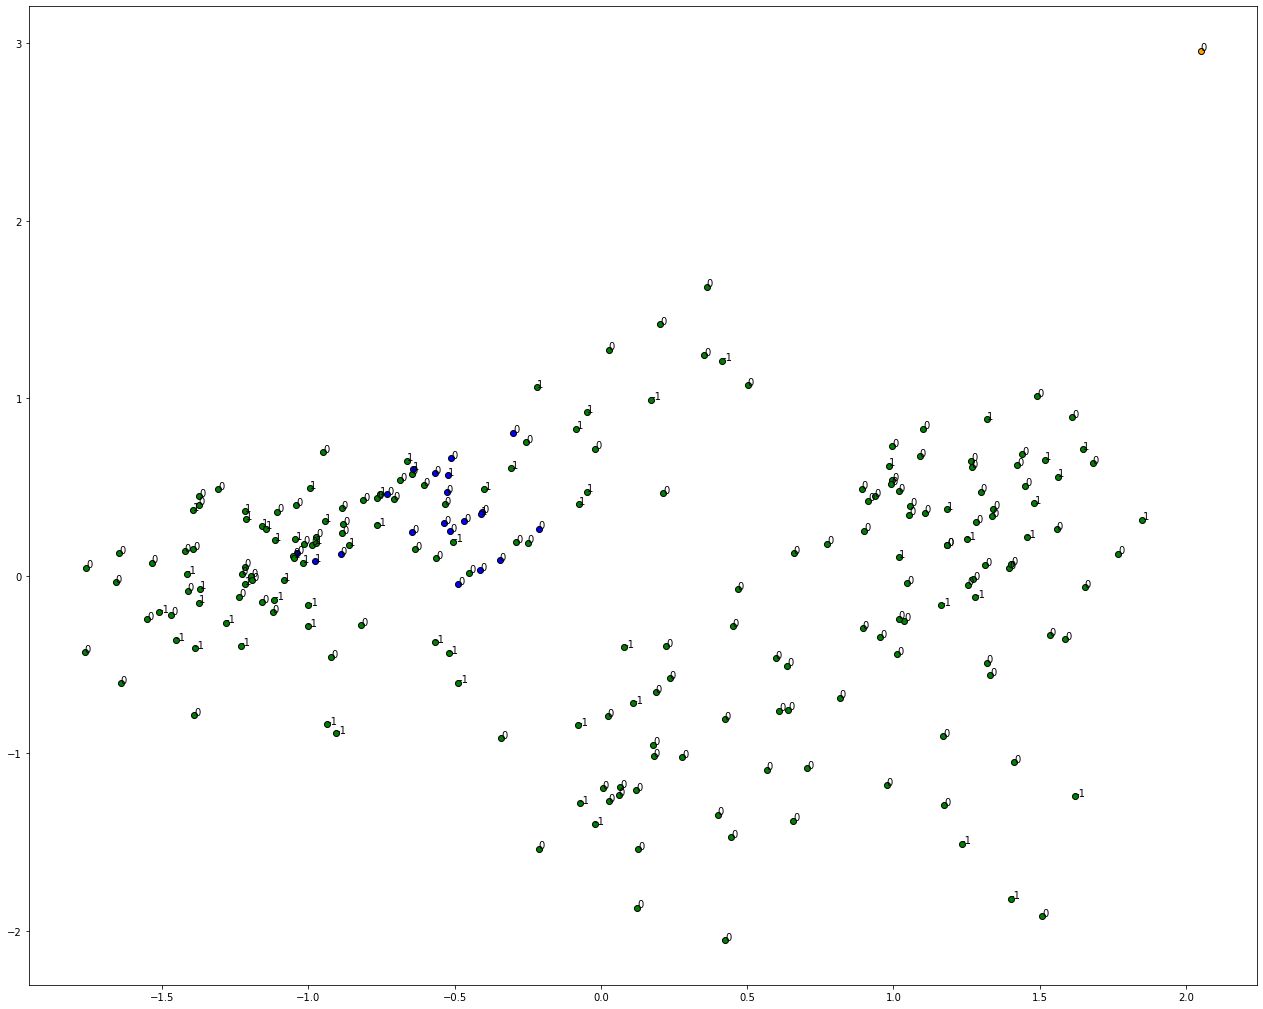

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2, random_state=0)
pcs = pca.fit_transform(w2v_feature_array)
labels = ap.labels_
categories = list(corpus_df['Category'])
plt.figure(figsize=(22, 18))

for i in range(len(labels)):
    label = labels[i]
    color = 'orange' if label == 0 else 'blue' if label == 1 else 'green'
    annotation_label = categories[i]
    x, y = pcs[i]
    plt.scatter(x, y, c=color, edgecolors='k')
    plt.annotate(annotation_label, xy=(x+1e-4, y+1e-3), xytext=(0, 0), textcoords='offset points')

# Load Wisconsin Breast Cancer Dataset

In [ ]:
import numpy as np
from sklearn.datasets import load_breast_cancer
import matplotlib.pyplot as plt

%matplotlib inline

# load data
data = load_breast_cancer()
X = data.data
y = data.target
print(X.shape, data.feature_names)

(569, 30) ['mean radius' 'mean texture' 'mean perimeter' 'mean area'
 'mean smoothness' 'mean compactness' 'mean concavity'
 'mean concave points' 'mean symmetry' 'mean fractal dimension'
 'radius error' 'texture error' 'perimeter error' 'area error'
 'smoothness error' 'compactness error' 'concavity error'
 'concave points error' 'symmetry error' 'fractal dimension error'
 'worst radius' 'worst texture' 'worst perimeter' 'worst area'
 'worst smoothness' 'worst compactness' 'worst concavity'
 'worst concave points' 'worst symmetry' 'worst fractal dimension']


In [ ]:
data.data[0]

array([  17.99    ,   10.38    ,  122.8     , 1001.      ,    0.1184  ,
          0.2776  ,    0.3001  ,    0.1471  ,    0.2419  ,    0.07871 ,
          1.095   ,    0.9053  ,    8.589   ,  153.4     ,    0.006399,
          0.04904 ,    0.05373 ,    0.01587 ,    0.03003 ,    0.006193,
         25.38    ,   17.33    ,  184.6     , 2019.      ,    0.1622  ,
          0.6656  ,    0.7119  ,    0.2654  ,    0.4601  ,    0.1189  ])

In [ ]:
data.feature_names

array(['mean radius', 'mean texture', 'mean perimeter', 'mean area',
       'mean smoothness', 'mean compactness', 'mean concavity',
       'mean concave points', 'mean symmetry', 'mean fractal dimension',
       'radius error', 'texture error', 'perimeter error', 'area error',
       'smoothness error', 'compactness error', 'concavity error',
       'concave points error', 'symmetry error',
       'fractal dimension error', 'worst radius', 'worst texture',
       'worst perimeter', 'worst area', 'worst smoothness',
       'worst compactness', 'worst concavity', 'worst concave points',
       'worst symmetry', 'worst fractal dimension'], dtype='<U23')

# Classification Model Evaluation Metrics

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print(X_train.shape, X_test.shape)

In [ ]:
from sklearn import linear_model

logistic = linear_model.LogisticRegression()
logistic.fit(X_train,y_train)

## Confusion Matrix

In [ ]:
import model_evaluation_utils as meu

In [ ]:
from sklearn import metrics
import pandas as pd

def display_confusion_matrix(true_labels, predicted_labels, classes=[1,0]):
    
    total_classes = len(classes)
    level_labels = [total_classes*[0], list(range(total_classes))]

    cm = metrics.confusion_matrix(y_true=true_labels, y_pred=predicted_labels, 
                                  labels=classes)
    cm_frame = pd.DataFrame(data=cm, 
                            columns=pd.MultiIndex.from_product([['Predicted:'], classes],), # names=level_labels 
                            index=pd.MultiIndex.from_product([['Actual:'], classes]))  # names=level_labels 
    print(cm_frame) 

In [ ]:
import model_evaluation_utils as meu

y_pred = logistic.predict(X_test)
display_confusion_matrix(true_labels=y_test, predicted_labels=y_pred, classes=[0, 1])

## True Positive, False Positive, True Negative and False Negative

In [ ]:
positive_class = 1
TP = 106
FP = 4
TN = 59
FN = 2

## Accuracy

In [ ]:
fw_acc = round(meu.metrics.accuracy_score(y_true=y_test, y_pred=y_pred), 5)
mc_acc = round((TP + TN) / (TP + TN + FP + FN), 5)
print('Framework Accuracy:', fw_acc)
print('Manually Computed Accuracy:', mc_acc)

## Precision

In [ ]:
fw_prec = round(meu.metrics.precision_score(y_true=y_test, y_pred=y_pred), 5)
mc_prec = round((TP) / (TP + FP), 5)
print('Framework Precision:', fw_prec)
print('Manually Computed Precision:', mc_prec)

## Recall

In [ ]:
fw_rec = round(meu.metrics.recall_score(y_true=y_test, y_pred=y_pred), 5)
mc_rec = round((TP) / (TP + FN), 5)
print('Framework Recall:', fw_rec)
print('Manually Computed Recall:', mc_rec)

## F1-Score

In [ ]:
fw_f1 = round(meu.metrics.f1_score(y_true=y_test, y_pred=y_pred), 5)
mc_f1 = round((2*mc_prec*mc_rec) / (mc_prec+mc_rec), 5)
print('Framework F1-Score:', fw_f1)
print('Manually Computed F1-Score:', mc_f1)

## ROC Curve and AUC

In [ ]:
meu.plot_model_roc_curve(clf=logistic, features=X_test, true_labels=y_test)

# Classification

In [9]:
!pip3 install pickle5
import pickle5 as pickle

     |████████████████████████████████| 133kB 7.6MB/s 
  Created wheel for pickle5: filename=pickle5-0.0.11-cp36-cp36m-linux_x86_64.whl size=218611 sha256=b935b4f72063b45e1b96be3c58c0a6f45c46733b26a3981597070fee4c577411
  Stored in directory: /root/.cache/pip/wheels/a6/90/95/f889ca4aa8b0e0c7f21c8470b6f5d6032f0390a3a141a9a3bd
Successfully built pickle5


In [8]:
import os
os.chdir(r'FOMC_04_pickle_data')
os.getcwd()

'/content/drive/My Drive/Colab_Data/FOMC_04_pickle_data'

In [10]:
# import pickle

FOMC_pickle = [0] * 222 # list(range(0,222))
FOMC_pickle_2 = [0] * 222

for i in range(0,222):
    name = str(i+1)+'.txt'    
    FOMC_pickle[i] = pickle.load(open(name, 'rb'))
    FOMC_pickle_2[i] = ' '.join(FOMC_pickle[i])

In [11]:
%cd ..

/content/drive/My Drive/Colab_Data


In [12]:
import pandas as pd
# df = pd.read_excel (r'Path where the Excel file is stored\File name.xlsx')
df = pd.read_excel(r'FOMC_02_excel_data/Fed_fund_rate_change.xlsx')

fund_rate_change = list(df.iloc[:,5])
fund_rate_change_date = list(df.iloc[:,1])

In [13]:
corpus_df = pd.DataFrame({'Document': FOMC_pickle_2, 
                          'Category': fund_rate_change[24:246]})
corpus_df = corpus_df[['Document', 'Category']]
print(corpus_df.head())

                                            Document  Category
0  inform review meet indic econom activ rose app...         0
1  inform review meet suggest econom activ expand...         0
2  inform review meet suggest pace econom expans ...         0
3  inform review meet provid mix read economi bal...         0
4  inform review committe suggest econom activ ex...         0


In [15]:
import numpy as np
print(len(np.array(FOMC_pickle_2))); print(len(np.array(fund_rate_change[24:246])))

222
222


In [16]:
up_index = []
down_index = []
unchanged_index = []

for i in range(24,246):
    if fund_rate_change[i] == 1:
        up_index.append(i-24)
    elif fund_rate_change[i] == -1:
        down_index.append(i-24)
    elif fund_rate_change[i] == 0:
        unchanged_index.append(i-24)
    else:
        print('Wrong !')

print(up_index)
print(len(up_index)); print(len(down_index)); print(len(unchanged_index))
print(len(up_index) + len(down_index) + len(unchanged_index))


import numpy as np
up_index = np.array(up_index)
down_index = np.array(down_index)
unchanged_index = np.array(unchanged_index)

[8, 9, 10, 12, 14, 16, 33, 51, 52, 54, 56, 57, 58, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 183, 191, 193, 195, 199, 201, 203, 205, 207]
39
30
153
222


In [18]:
FOMC_pickle_2 = np.array(FOMC_pickle_2)
fund_rate_change_2 = np.array(fund_rate_change[24:246])

In [22]:
sth = np.array(FOMC_pickle_2[up_index])

In [24]:
print(np.array(fund_rate_change[24:246])[up_index])

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1]


In [29]:
from sklearn.model_selection import train_test_split

train_corpus_up, test_corpus_up, train_label_nums_up, test_label_nums_up =\
                                 train_test_split(np.array(FOMC_pickle_2[up_index]), fund_rate_change_2[up_index], 
                                                  test_size=0.3, random_state=2021)
# train_label_names, test_label_names
train_corpus_up.shape, test_corpus_up.shape

((27,), (12,))

In [30]:
train_corpus_down, test_corpus_down, train_label_nums_down, test_label_nums_down =\
                                 train_test_split(np.array(FOMC_pickle_2[down_index]), fund_rate_change_2[down_index], 
                                                  test_size=0.3, random_state=2021)
# train_label_names, test_label_names 
train_corpus_down.shape, test_corpus_down.shape

((21,), (9,))

In [31]:
train_corpus_unchanged, test_corpus_unchanged, train_label_nums_unchanged, test_label_nums_unchanged =\
                                 train_test_split(np.array(FOMC_pickle_2[unchanged_index]), fund_rate_change_2[unchanged_index], 
                                                  test_size=0.3, random_state=2021)
# train_label_names, test_label_names 
train_corpus_unchanged.shape, test_corpus_unchanged.shape

((107,), (46,))

In [40]:
train_corpus = np.r_[train_corpus_up, train_corpus_down, train_corpus_unchanged]
test_corpus = np.r_[test_corpus_up, test_corpus_down, test_corpus_unchanged]
train_label_nums = np.r_[train_label_nums_up, train_label_nums_down, train_label_nums_unchanged]
test_label_nums = np.r_[test_label_nums_up, test_label_nums_down, test_label_nums_unchanged]

In [34]:
print(len(train_corpus_up)); print(len(train_corpus_down)); print(len(train_corpus))

27
21
48


In [41]:
print(len(train_corpus)); print(len(test_corpus)); print()
print(len(train_label_nums)); print(len(test_label_nums))

155
67

155
67


In [42]:
from collections import Counter

trd = dict(Counter(train_label_nums))
tsd = dict(Counter(test_label_nums))

(pd.DataFrame([[key, trd[key], tsd[key]] for key in trd], 
             columns=['Target Label', 'Train Count', 'Test Count'])
.sort_values(by=['Train Count', 'Test Count'],
             ascending=False))

,Target Label,Train Count,Test Count
2,0,107,46
0,1,27,12
1,-1,21,9


In [43]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import cross_val_score

# build BOW features on train articles
cv = CountVectorizer(binary=False, min_df=0.0, max_df=1.0)
cv_train_features = cv.fit_transform(train_corpus)

In [44]:
# transform test articles into features
cv_test_features = cv.transform(test_corpus)

In [45]:
print('BOW model:> Train features shape:', cv_train_features.shape, ' Test features shape:', cv_test_features.shape)

BOW model:> Train features shape: (155, 3853)  Test features shape: (67, 3853)


In [46]:
from sklearn.naive_bayes import MultinomialNB

mnb = MultinomialNB(alpha=1)
mnb.fit(cv_train_features, train_label_nums)
mnb_bow_cv_scores = cross_val_score(mnb, cv_train_features, train_label_nums, cv=5)
mnb_bow_cv_mean_score = np.mean(mnb_bow_cv_scores)
print('CV Accuracy (5-fold):', mnb_bow_cv_scores)
print('Mean CV Accuracy:', mnb_bow_cv_mean_score)
mnb_bow_test_score = mnb.score(cv_test_features, test_label_nums)
print('Test Accuracy:', mnb_bow_test_score)

CV Accuracy (5-fold): [0.70967742 0.67741935 0.64516129 0.67741935 0.64516129]
Mean CV Accuracy: 0.6709677419354838
Test Accuracy: 0.7164179104477612


In [47]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(penalty='l2', max_iter=2000, C=1, random_state=42)
lr.fit(cv_train_features, train_label_nums)
lr_bow_cv_scores = cross_val_score(lr, cv_train_features, train_label_nums, cv=5)
lr_bow_cv_mean_score = np.mean(lr_bow_cv_scores)
print('CV Accuracy (5-fold):', lr_bow_cv_scores)
print('Mean CV Accuracy:', lr_bow_cv_mean_score)
lr_bow_test_score = lr.score(cv_test_features, test_label_nums)
print('Test Accuracy:', lr_bow_test_score)

CV Accuracy (5-fold): [0.83870968 0.77419355 0.80645161 0.77419355 0.83870968]
Mean CV Accuracy: 0.8064516129032258
Test Accuracy: 0.8656716417910447


In [48]:
from sklearn.svm import LinearSVC

svm = LinearSVC(penalty='l2', C=1, random_state=42)
svm.fit(cv_train_features, train_label_nums)
svm_bow_cv_scores = cross_val_score(svm, cv_train_features, train_label_nums, cv=5)
svm_bow_cv_mean_score = np.mean(svm_bow_cv_scores)
print('CV Accuracy (5-fold):', svm_bow_cv_scores)
print('Mean CV Accuracy:', svm_bow_cv_mean_score)
svm_bow_test_score = svm.score(cv_test_features, test_label_nums)
print('Test Accuracy:', svm_bow_test_score)

CV Accuracy (5-fold): [0.80645161 0.80645161 0.80645161 0.77419355 0.83870968]
Mean CV Accuracy: 0.8064516129032258
Test Accuracy: 0.8507462686567164


In [49]:
from sklearn.linear_model import SGDClassifier

svm_sgd = SGDClassifier(loss='hinge', penalty='l2', max_iter=100, random_state=42)
svm_sgd.fit(cv_train_features, train_label_nums)
svmsgd_bow_cv_scores = cross_val_score(svm_sgd, cv_train_features, train_label_nums, cv=5)
svmsgd_bow_cv_mean_score = np.mean(svmsgd_bow_cv_scores)
print('CV Accuracy (5-fold):', svmsgd_bow_cv_scores)
print('Mean CV Accuracy:', svmsgd_bow_cv_mean_score)
svmsgd_bow_test_score = svm_sgd.score(cv_test_features, test_label_nums)
print('Test Accuracy:', svmsgd_bow_test_score)

CV Accuracy (5-fold): [0.83870968 0.77419355 0.74193548 0.74193548 0.77419355]
Mean CV Accuracy: 0.7741935483870968
Test Accuracy: 0.835820895522388


In [50]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(n_estimators=10, random_state=42)
rfc.fit(cv_train_features, train_label_nums)
rfc_bow_cv_scores = cross_val_score(rfc, cv_train_features, train_label_nums, cv=5)
rfc_bow_cv_mean_score = np.mean(rfc_bow_cv_scores)
print('CV Accuracy (5-fold):', rfc_bow_cv_scores)
print('Mean CV Accuracy:', rfc_bow_cv_mean_score)
rfc_bow_test_score = rfc.score(cv_test_features, test_label_nums)
print('Test Accuracy:', rfc_bow_test_score)

CV Accuracy (5-fold): [0.70967742 0.70967742 0.67741935 0.77419355 0.74193548]
Mean CV Accuracy: 0.7225806451612904
Test Accuracy: 0.6865671641791045


In [51]:
from sklearn.ensemble import GradientBoostingClassifier

gbc = GradientBoostingClassifier(n_estimators=10, random_state=42)
gbc.fit(cv_train_features, train_label_nums)
gbc_bow_cv_scores = cross_val_score(gbc, cv_train_features, train_label_nums, cv=5)
gbc_bow_cv_mean_score = np.mean(gbc_bow_cv_scores)
print('CV Accuracy (5-fold):', gbc_bow_cv_scores)
print('Mean CV Accuracy:', gbc_bow_cv_mean_score)
gbc_bow_test_score = gbc.score(cv_test_features, test_label_nums)
print('Test Accuracy:', gbc_bow_test_score)

CV Accuracy (5-fold): [0.80645161 0.74193548 0.64516129 0.77419355 0.77419355]
Mean CV Accuracy: 0.7483870967741936
Test Accuracy: 0.7910447761194029


In [52]:
from sklearn.feature_extraction.text import TfidfVectorizer

# build BOW features on train articles
tv = TfidfVectorizer(use_idf=True, min_df=0.0, max_df=1.0)
tv_train_features = tv.fit_transform(train_corpus)

In [53]:
# transform test articles into features
tv_test_features = tv.transform(test_corpus)

In [54]:
print('TFIDF model:> Train features shape:', tv_train_features.shape, ' Test features shape:', tv_test_features.shape)

TFIDF model:> Train features shape: (155, 3853)  Test features shape: (67, 3853)


In [55]:
mnb = MultinomialNB(alpha=1)
mnb.fit(tv_train_features, train_label_nums)
mnb_tfidf_cv_scores = cross_val_score(mnb, tv_train_features, train_label_nums, cv=5)
mnb_tfidf_cv_mean_score = np.mean(mnb_tfidf_cv_scores)
print('CV Accuracy (5-fold):', mnb_tfidf_cv_scores)
print('Mean CV Accuracy:', mnb_tfidf_cv_mean_score)
mnb_tfidf_test_score = mnb.score(tv_test_features, test_label_nums)
print('Test Accuracy:', mnb_tfidf_test_score)

CV Accuracy (5-fold): [0.67741935 0.67741935 0.67741935 0.70967742 0.70967742]
Mean CV Accuracy: 0.6903225806451614
Test Accuracy: 0.6865671641791045


In [56]:
lr = LogisticRegression(penalty='l2', max_iter=100, C=1, random_state=42)
lr.fit(tv_train_features, train_label_nums)
lr_tfidf_cv_scores = cross_val_score(lr, tv_train_features, train_label_nums, cv=5)
lr_tfidf_cv_mean_score = np.mean(lr_tfidf_cv_scores)
print('CV Accuracy (5-fold):', lr_tfidf_cv_scores)
print('Mean CV Accuracy:', lr_tfidf_cv_mean_score)
lr_tfidf_test_score = lr.score(tv_test_features, test_label_nums)
print('Test Accuracy:', lr_tfidf_test_score)

CV Accuracy (5-fold): [0.67741935 0.67741935 0.67741935 0.70967742 0.70967742]
Mean CV Accuracy: 0.6903225806451614
Test Accuracy: 0.6865671641791045


In [57]:
svm = LinearSVC(penalty='l2', C=1, random_state=42)
svm.fit(tv_train_features, train_label_nums)
svm_tfidf_cv_scores = cross_val_score(svm, tv_train_features, train_label_nums, cv=5)
svm_tfidf_cv_mean_score = np.mean(svm_tfidf_cv_scores)
print('CV Accuracy (5-fold):', svm_tfidf_cv_scores)
print('Mean CV Accuracy:', svm_tfidf_cv_mean_score)
svm_tfidf_test_score = svm.score(tv_test_features, test_label_nums)
print('Test Accuracy:', svm_tfidf_test_score)

CV Accuracy (5-fold): [0.70967742 0.70967742 0.77419355 0.74193548 0.70967742]
Mean CV Accuracy: 0.7290322580645162
Test Accuracy: 0.7611940298507462


In [58]:
svm_sgd = SGDClassifier(loss='hinge', penalty='l2', max_iter=40, random_state=42)
svm_sgd.fit(tv_train_features, train_label_nums)
svmsgd_tfidf_cv_scores = cross_val_score(svm_sgd, tv_train_features, train_label_nums, cv=5)
svmsgd_tfidf_cv_mean_score = np.mean(svmsgd_tfidf_cv_scores)
print('CV Accuracy (5-fold):', svmsgd_tfidf_cv_scores)
print('Mean CV Accuracy:', svmsgd_tfidf_cv_mean_score)
svmsgd_tfidf_test_score = svm_sgd.score(tv_test_features, test_label_nums)
print('Test Accuracy:', svmsgd_tfidf_test_score)

CV Accuracy (5-fold): [0.74193548 0.74193548 0.77419355 0.80645161 0.80645161]
Mean CV Accuracy: 0.7741935483870968
Test Accuracy: 0.7761194029850746


In [59]:
rfc = RandomForestClassifier(n_estimators=10, random_state=42)
rfc.fit(tv_train_features, train_label_nums)
rfc_tfidf_cv_scores = cross_val_score(rfc, tv_train_features, train_label_nums, cv=5)
rfc_tfidf_cv_mean_score = np.mean(rfc_tfidf_cv_scores)
print('CV Accuracy (5-fold):', rfc_tfidf_cv_scores)
print('Mean CV Accuracy:', rfc_tfidf_cv_mean_score)
rfc_tfidf_test_score = rfc.score(tv_test_features, test_label_nums)
print('Test Accuracy:', rfc_tfidf_test_score)

CV Accuracy (5-fold): [0.77419355 0.67741935 0.67741935 0.74193548 0.70967742]
Mean CV Accuracy: 0.7161290322580646
Test Accuracy: 0.7910447761194029


In [60]:
gbc = GradientBoostingClassifier(n_estimators=10, random_state=42)
gbc.fit(tv_train_features, train_label_nums)
gbc_tfidf_cv_scores = cross_val_score(gbc, tv_train_features, train_label_nums, cv=5)
gbc_tfidf_cv_mean_score = np.mean(gbc_tfidf_cv_scores)
print('CV Accuracy (5-fold):', gbc_tfidf_cv_scores)
print('Mean CV Accuracy:', gbc_tfidf_cv_mean_score)
gbc_tfidf_test_score = gbc.score(tv_test_features, test_label_nums)
print('Test Accuracy:', gbc_tfidf_test_score)

CV Accuracy (5-fold): [0.77419355 0.77419355 0.64516129 0.74193548 0.77419355]
Mean CV Accuracy: 0.7419354838709677
Test Accuracy: 0.7761194029850746


In [61]:
pd.DataFrame([['Naive Bayes', mnb_bow_cv_mean_score, mnb_bow_test_score, 
               mnb_tfidf_cv_mean_score, mnb_tfidf_test_score],
              ['Logistic Regression', lr_bow_cv_mean_score, lr_bow_test_score, 
               lr_tfidf_cv_mean_score, lr_tfidf_test_score],
              ['Linear SVM', svm_bow_cv_mean_score, svm_bow_test_score, 
               svm_tfidf_cv_mean_score, svm_tfidf_test_score],
              ['Linear SVM (SGD)', svmsgd_bow_cv_mean_score, svmsgd_bow_test_score, 
               svmsgd_tfidf_cv_mean_score, svmsgd_tfidf_test_score],
              ['Random Forest', rfc_bow_cv_mean_score, rfc_bow_test_score, 
               rfc_tfidf_cv_mean_score, rfc_tfidf_test_score],
              ['Gradient Boosted Machines', gbc_bow_cv_mean_score, gbc_bow_test_score, 
               gbc_tfidf_cv_mean_score, gbc_tfidf_test_score]],
             columns=['Model', 'CV Score (TF)', 'Test Score (TF)', 'CV Score (TF-IDF)', 'Test Score (TF-IDF)'],
             ).T

,0,1,2,3,4,5
Model,Naive Bayes,Logistic Regression,Linear SVM,Linear SVM (SGD),Random Forest,Gradient Boosted Machines
CV Score (TF),0.670968,0.806452,0.806452,0.774194,0.722581,0.748387
Test Score (TF),0.716418,0.865672,0.850746,0.835821,0.686567,0.791045
CV Score (TF-IDF),0.690323,0.690323,0.729032,0.774194,0.716129,0.741935
Test Score (TF-IDF),0.686567,0.686567,0.761194,0.776119,0.791045,0.776119


In [62]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer

mnb_pipeline = Pipeline([('tfidf', TfidfVectorizer()),
                        ('mnb', MultinomialNB())
                       ])

param_grid = {'tfidf__ngram_range': [(1, 1), (1, 2)],
              'mnb__alpha': [1e-5, 1e-4, 1e-2, 1e-1, 1]
}

gs_mnb = GridSearchCV(mnb_pipeline, param_grid, cv=5, verbose=2)
gs_mnb = gs_mnb.fit(train_corpus, train_label_nums)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] mnb__alpha=1e-05, tfidf__ngram_range=(1, 1) .....................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ...... mnb__alpha=1e-05, tfidf__ngram_range=(1, 1), total=   0.3s
[CV] mnb__alpha=1e-05, tfidf__ngram_range=(1, 1) .....................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


[CV] ...... mnb__alpha=1e-05, tfidf__ngram_range=(1, 1), total=   0.3s
[CV] mnb__alpha=1e-05, tfidf__ngram_range=(1, 1) .....................
[CV] ...... mnb__alpha=1e-05, tfidf__ngram_range=(1, 1), total=   0.3s
[CV] mnb__alpha=1e-05, tfidf__ngram_range=(1, 1) .....................
[CV] ...... mnb__alpha=1e-05, tfidf__ngram_range=(1, 1), total=   0.3s
[CV] mnb__alpha=1e-05, tfidf__ngram_range=(1, 1) .....................
[CV] ...... mnb__alpha=1e-05, tfidf__ngram_range=(1, 1), total=   0.3s
[CV] mnb__alpha=1e-05, tfidf__ngram_range=(1, 2) .....................
[CV] ...... mnb__alpha=1e-05, tfidf__ngram_range=(1, 2), total=   1.1s
[CV] mnb__alpha=1e-05, tfidf__ngram_range=(1, 2) .....................
[CV] ...... mnb__alpha=1e-05, tfidf__ngram_range=(1, 2), total=   1.1s
[CV] mnb__alpha=1e-05, tfidf__ngram_range=(1, 2) .....................
[CV] ...... mnb__alpha=1e-05, tfidf__ngram_range=(1, 2), total=   1.1s
[CV] mnb__alpha=1e-05, tfidf__ngram_range=(1, 2) .....................
[CV] .

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   34.0s finished


In [63]:
gs_mnb.best_estimator_.get_params()

{'memory': None,
 'mnb': MultinomialNB(alpha=0.01, class_prior=None, fit_prior=True),
 'mnb__alpha': 0.01,
 'mnb__class_prior': None,
 'mnb__fit_prior': True,
 'steps': [('tfidf',
   TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                   dtype=<class 'numpy.float64'>, encoding='utf-8',
                   input='content', lowercase=True, max_df=1.0, max_features=None,
                   min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                   smooth_idf=True, stop_words=None, strip_accents=None,
                   sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                   tokenizer=None, use_idf=True, vocabulary=None)),
  ('mnb', MultinomialNB(alpha=0.01, class_prior=None, fit_prior=True))],
 'tfidf': TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                 dtype=<class 'numpy.float64'>, encoding='utf-8',
                 input='content', lowercase=True, max_df=1.0, max_features=None,
  

In [64]:
cv_results = gs_mnb.cv_results_
results_df = pd.DataFrame({'rank': cv_results['rank_test_score'],
                           'params': cv_results['params'], 
                           'cv score (mean)': cv_results['mean_test_score'], 
                           'cv score (std)': cv_results['std_test_score']} 
              )
results_df = results_df.sort_values(by=['rank'], ascending=True)
pd.set_option('display.max_colwidth', 100)
results_df

,rank,params,cv score (mean),cv score (std)
4,1,"{'mnb__alpha': 0.01, 'tfidf__ngram_range': (1, 1)}",0.722581,0.025806
0,2,"{'mnb__alpha': 1e-05, 'tfidf__ngram_range': (1, 1)}",0.709677,0.020402
2,2,"{'mnb__alpha': 0.0001, 'tfidf__ngram_range': (1, 1)}",0.709677,0.020402
3,4,"{'mnb__alpha': 0.0001, 'tfidf__ngram_range': (1, 2)}",0.696774,0.015803
5,4,"{'mnb__alpha': 0.01, 'tfidf__ngram_range': (1, 2)}",0.696774,0.015803
1,6,"{'mnb__alpha': 1e-05, 'tfidf__ngram_range': (1, 2)}",0.690323,0.015803
6,6,"{'mnb__alpha': 0.1, 'tfidf__ngram_range': (1, 1)}",0.690323,0.015803
7,6,"{'mnb__alpha': 0.1, 'tfidf__ngram_range': (1, 2)}",0.690323,0.015803
8,6,"{'mnb__alpha': 1, 'tfidf__ngram_range': (1, 1)}",0.690323,0.015803
9,6,"{'mnb__alpha': 1, 'tfidf__ngram_range': (1, 2)}",0.690323,0.015803


In [65]:
best_mnb_test_score = gs_mnb.score(test_corpus, test_label_nums)
print('Test Accuracy :', best_mnb_test_score)

Test Accuracy : 0.746268656716418


In [66]:
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import LinearSVC

In [67]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

lr_pipeline = Pipeline([('tfidf', TfidfVectorizer()),
                        ('lr', LogisticRegression(penalty='l2', max_iter=100, random_state=42))
                       ])

param_grid = {'tfidf__ngram_range': [(1, 1), (1, 2)],
              'lr__C': [1, 5, 10]
}

gs_lr = GridSearchCV(lr_pipeline, param_grid, cv=5, verbose=2)
gs_lr = gs_lr.fit(train_corpus, train_label_nums)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] lr__C=1, tfidf__ngram_range=(1, 1) ..............................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ............... lr__C=1, tfidf__ngram_range=(1, 1), total=   0.4s
[CV] lr__C=1, tfidf__ngram_range=(1, 1) ..............................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s


[CV] ............... lr__C=1, tfidf__ngram_range=(1, 1), total=   0.5s
[CV] lr__C=1, tfidf__ngram_range=(1, 1) ..............................
[CV] ............... lr__C=1, tfidf__ngram_range=(1, 1), total=   0.4s
[CV] lr__C=1, tfidf__ngram_range=(1, 1) ..............................
[CV] ............... lr__C=1, tfidf__ngram_range=(1, 1), total=   0.6s
[CV] lr__C=1, tfidf__ngram_range=(1, 1) ..............................
[CV] ............... lr__C=1, tfidf__ngram_range=(1, 1), total=   0.6s
[CV] lr__C=1, tfidf__ngram_range=(1, 2) ..............................
[CV] ............... lr__C=1, tfidf__ngram_range=(1, 2), total=   2.9s
[CV] lr__C=1, tfidf__ngram_range=(1, 2) ..............................
[CV] ............... lr__C=1, tfidf__ngram_range=(1, 2), total=   2.7s
[CV] lr__C=1, tfidf__ngram_range=(1, 2) ..............................
[CV] ............... lr__C=1, tfidf__ngram_range=(1, 2), total=   2.8s
[CV] lr__C=1, tfidf__ngram_range=(1, 2) ..............................
[CV] .

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:  1.2min finished


In [68]:
gs_lr.best_estimator_

Pipeline(memory=None,
         steps=[('tfidf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('lr',
                 LogisticRegression(C=10, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1

In [69]:
best_lr_test_score = gs_lr.score(test_corpus, test_label_nums)
print('Test Accuracy :', best_lr_test_score)

Test Accuracy : 0.7910447761194029


In [70]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

svm_pipeline = Pipeline([('tfidf', TfidfVectorizer()),
                        ('svm', LinearSVC(random_state=42))
                       ])

param_grid = {'tfidf__ngram_range': [(1, 1), (1, 2)],
              'svm__C': [0.01, 0.1, 1, 5]
}

gs_svm = GridSearchCV(svm_pipeline, param_grid, cv=5, verbose=2)
gs_svm = gs_svm.fit(train_corpus, train_label_nums)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV] svm__C=0.01, tfidf__ngram_range=(1, 1) ..........................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ........... svm__C=0.01, tfidf__ngram_range=(1, 1), total=   0.3s
[CV] svm__C=0.01, tfidf__ngram_range=(1, 1) ..........................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


[CV] ........... svm__C=0.01, tfidf__ngram_range=(1, 1), total=   0.3s
[CV] svm__C=0.01, tfidf__ngram_range=(1, 1) ..........................
[CV] ........... svm__C=0.01, tfidf__ngram_range=(1, 1), total=   0.3s
[CV] svm__C=0.01, tfidf__ngram_range=(1, 1) ..........................
[CV] ........... svm__C=0.01, tfidf__ngram_range=(1, 1), total=   0.3s
[CV] svm__C=0.01, tfidf__ngram_range=(1, 1) ..........................
[CV] ........... svm__C=0.01, tfidf__ngram_range=(1, 1), total=   0.3s
[CV] svm__C=0.01, tfidf__ngram_range=(1, 2) ..........................
[CV] ........... svm__C=0.01, tfidf__ngram_range=(1, 2), total=   1.1s
[CV] svm__C=0.01, tfidf__ngram_range=(1, 2) ..........................
[CV] ........... svm__C=0.01, tfidf__ngram_range=(1, 2), total=   1.1s
[CV] svm__C=0.01, tfidf__ngram_range=(1, 2) ..........................
[CV] ........... svm__C=0.01, tfidf__ngram_range=(1, 2), total=   1.1s
[CV] svm__C=0.01, tfidf__ngram_range=(1, 2) ..........................
[CV] .

[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:   29.5s finished


In [71]:
gs_svm.best_estimator_.get_params()

{'memory': None,
 'steps': [('tfidf',
   TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                   dtype=<class 'numpy.float64'>, encoding='utf-8',
                   input='content', lowercase=True, max_df=1.0, max_features=None,
                   min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                   smooth_idf=True, stop_words=None, strip_accents=None,
                   sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                   tokenizer=None, use_idf=True, vocabulary=None)),
  ('svm', LinearSVC(C=5, class_weight=None, dual=True, fit_intercept=True,
             intercept_scaling=1, loss='squared_hinge', max_iter=1000,
             multi_class='ovr', penalty='l2', random_state=42, tol=0.0001,
             verbose=0))],
 'svm': LinearSVC(C=5, class_weight=None, dual=True, fit_intercept=True,
           intercept_scaling=1, loss='squared_hinge', max_iter=1000,
           multi_class='ovr', penalty='l2', random_sta

In [72]:
best_svm_test_score = gs_svm.score(test_corpus, test_label_nums)
print('Test Accuracy :', best_svm_test_score)

Test Accuracy : 0.835820895522388


In [73]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

sgd_pipeline = Pipeline([('tfidf', TfidfVectorizer()),
                        ('sgd', SGDClassifier(random_state=42))
                       ])

param_grid = {'tfidf__ngram_range': [(1, 1), (1, 2)],
              'sgd__alpha': [1e-7, 1e-6, 1e-5, 1e-4]
}

gs_sgd = GridSearchCV(sgd_pipeline, param_grid, cv=5, verbose=2)
gs_sgd = gs_sgd.fit(train_corpus, train_label_nums)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV] sgd__alpha=1e-07, tfidf__ngram_range=(1, 1) .....................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ...... sgd__alpha=1e-07, tfidf__ngram_range=(1, 1), total=   0.3s
[CV] sgd__alpha=1e-07, tfidf__ngram_range=(1, 1) .....................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


[CV] ...... sgd__alpha=1e-07, tfidf__ngram_range=(1, 1), total=   0.3s
[CV] sgd__alpha=1e-07, tfidf__ngram_range=(1, 1) .....................
[CV] ...... sgd__alpha=1e-07, tfidf__ngram_range=(1, 1), total=   0.3s
[CV] sgd__alpha=1e-07, tfidf__ngram_range=(1, 1) .....................
[CV] ...... sgd__alpha=1e-07, tfidf__ngram_range=(1, 1), total=   0.3s
[CV] sgd__alpha=1e-07, tfidf__ngram_range=(1, 1) .....................
[CV] ...... sgd__alpha=1e-07, tfidf__ngram_range=(1, 1), total=   0.3s
[CV] sgd__alpha=1e-07, tfidf__ngram_range=(1, 2) .....................
[CV] ...... sgd__alpha=1e-07, tfidf__ngram_range=(1, 2), total=   1.2s
[CV] sgd__alpha=1e-07, tfidf__ngram_range=(1, 2) .....................
[CV] ...... sgd__alpha=1e-07, tfidf__ngram_range=(1, 2), total=   1.2s
[CV] sgd__alpha=1e-07, tfidf__ngram_range=(1, 2) .....................
[CV] ...... sgd__alpha=1e-07, tfidf__ngram_range=(1, 2), total=   1.2s
[CV] sgd__alpha=1e-07, tfidf__ngram_range=(1, 2) .....................
[CV] .

[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:   29.8s finished


In [74]:
gs_sgd.best_estimator_.get_params()

{'memory': None,
 'sgd': SGDClassifier(alpha=1e-07, average=False, class_weight=None,
               early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
               l1_ratio=0.15, learning_rate='optimal', loss='hinge',
               max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
               power_t=0.5, random_state=42, shuffle=True, tol=0.001,
               validation_fraction=0.1, verbose=0, warm_start=False),
 'sgd__alpha': 1e-07,
 'sgd__average': False,
 'sgd__class_weight': None,
 'sgd__early_stopping': False,
 'sgd__epsilon': 0.1,
 'sgd__eta0': 0.0,
 'sgd__fit_intercept': True,
 'sgd__l1_ratio': 0.15,
 'sgd__learning_rate': 'optimal',
 'sgd__loss': 'hinge',
 'sgd__max_iter': 1000,
 'sgd__n_iter_no_change': 5,
 'sgd__n_jobs': None,
 'sgd__penalty': 'l2',
 'sgd__power_t': 0.5,
 'sgd__random_state': 42,
 'sgd__shuffle': True,
 'sgd__tol': 0.001,
 'sgd__validation_fraction': 0.1,
 'sgd__verbose': 0,
 'sgd__warm_start': False,
 'steps': [('tfidf',
 

In [75]:
best_sgd_test_score = gs_sgd.score(test_corpus, test_label_nums)
print('Test Accuracy :', best_sgd_test_score)

Test Accuracy : 0.835820895522388


In [75]:
%cd ..

In [76]:
%pwd

'/content/drive/My Drive/Colab_Data'

In [79]:
import model_evaluation_utils as meu

In [80]:
mnb_predictions = gs_mnb.predict(test_corpus)
unique_classes = list(set(test_label_nums))
meu.get_metrics(true_labels=test_label_nums, predicted_labels=mnb_predictions)

Accuracy: 0.7463
Precision: 0.7751
Recall: 0.7463
F1 Score: 0.6939


In [81]:
meu.display_classification_report(true_labels=test_label_nums, 
                                  predicted_labels=mnb_predictions, classes=unique_classes)

              precision    recall  f1-score   support

           0       0.74      0.98      0.84        46
           1       1.00      0.25      0.40        12
          -1       0.67      0.22      0.33         9

    accuracy                           0.75        67
   macro avg       0.80      0.48      0.52        67
weighted avg       0.78      0.75      0.69        67



In [82]:
data_labels_map = dict(zip(np.array(fund_rate_change[24:246]),  np.array(fund_rate_change[24:246])))

In [83]:
label_data_map = {v:k for k, v in data_labels_map.items()}
label_map_df = pd.DataFrame(list(label_data_map.items()), columns=['Label Name', 'Label Number'])
label_map_df

,Label Name,Label Number
0,0,0
1,1,1
2,-1,-1


In [84]:
import model_evaluation_utils as meu

In [85]:
import model_evaluation_utils as meu
from sklearn import metrics
import pandas as pd

def display_confusion_matrix(true_labels, predicted_labels, classes=[1,0]):
    
    total_classes = len(classes)
    level_labels = [total_classes*[0], list(range(total_classes))]

    cm = metrics.confusion_matrix(y_true=true_labels, y_pred=predicted_labels, 
                                  labels=classes)
    cm_frame = pd.DataFrame(data=cm, 
                            columns=pd.MultiIndex.from_product([['Predicted:'], classes]), # names=level_labels 
                            index=pd.MultiIndex.from_product([['Actual:'], classes]))  # names=level_labels 
    print(cm_frame) 

In [86]:
unique_class_nums = label_map_df['Label Number'].values
mnb_prediction_class_nums = [label_data_map[item] for item in mnb_predictions]

meu.display_confusion_matrix(true_labels=test_label_nums, 
                             predicted_labels=mnb_prediction_class_nums, classes=unique_class_nums)

           Predicted:      
                    0  1 -1
Actual:  0         45  0  1
         1          9  3  0
        -1          7  0  2


In [87]:
def display_confusion_matrix_pretty(true_labels, predicted_labels, classes=[1,0]):
    
    total_classes = len(classes)
    level_labels = [total_classes*[0], list(range(total_classes))]

    cm = metrics.confusion_matrix(y_true=true_labels, y_pred=predicted_labels, 
                                  labels=classes)
    cm_frame = pd.DataFrame(data=cm, 
                            columns=pd.MultiIndex.from_product([['Predicted:'], classes]), 
                            index=pd.MultiIndex.from_product([['Actual:'], classes])) 
    return cm_frame

In [88]:
display_confusion_matrix_pretty(true_labels=test_label_nums, 
                             predicted_labels=mnb_prediction_class_nums, classes=unique_class_nums)

Predicted:      
                    0  1 -1
Actual:  0         45  0  1
         1          9  3  0
        -1          7  0  2

In [89]:
unique_classes = label_map_df['Label Name'].values
display_confusion_matrix_pretty(true_labels=test_label_nums, 
                                    predicted_labels=mnb_predictions, classes=unique_classes)

Predicted:      
                    0  1 -1
Actual:  0         45  0  1
         1          9  3  0
        -1          7  0  2

In [90]:
label_map_df[label_map_df['Label Number'].isin([0, 1, ])]

,Label Name,Label Number
0,0,0
1,1,1


In [91]:
train_idx, test_idx = train_test_split(np.array(range(222)), test_size=0.33, random_state=42)
test_idx

array([154, 215,  15, 173, 158, 125,  97,  25,  60,  68, 126, 163, 142,
       115,  45,   9, 100,  96,  18, 176,  82,  30, 190,  66, 111,  55,
        67, 170, 118,  69,  93,  16, 109, 155, 112, 143, 197, 211,  79,
       139, 140, 119, 219,  84, 124,  73, 150,  95, 117,  75, 101, 146,
       141,  38,  24, 180, 181, 195, 127,  29,  19, 164, 198, 206, 113,
         5,  56, 182, 135,  86,  65, 207, 194, 132])

In [98]:
predict_probas = gs_mnb.predict_proba(test_corpus).max(axis=1)
test_df = df.iloc[:,0]
test_df['Predicted Name'] = mnb_predictions
test_df['Predicted Confidence'] = predict_probas
test_df.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


0    1
1    2
2    3
3    4
4    5
Name: Number, dtype: object

In [93]:
pd.set_option('display.max_colwidth', 200)
res_df = (test_df[(test_df['Target Name'] == 'talk.religion.misc') & (test_df['Predicted Name'] == 'soc.religion.christian')]
       .sort_values(by=['Predicted Confidence'], ascending=False).head(5))
res_df

NameError: ignored

In [94]:
pd.set_option('display.max_colwidth', 200)
res_df = (test_df[(test_df['Target Name'] == 'talk.religion.misc') & (test_df['Predicted Name'] == 'alt.atheism')]
       .sort_values(by=['Predicted Confidence'], ascending=False).head(5))
res_df

NameError: ignored

#### =========================

In [ ]:
 >>> import nltk
 >>> nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
import pandas as pd
import numpy as np
import text_normalizer as tn

In [ ]:
from sklearn.model_selection import train_test_split

train_corpus, test_corpus, train_label_nums, test_label_nums =\
                                 train_test_split(np.array(FOMC_pickle_2), np.array(fund_rate_change[24:246]), 
                                                  test_size=0.33, random_state=42)
# train_label_names, test_label_names 
train_corpus.shape, test_corpus.shape

((148,), (74,))

In [ ]:
tokenized_train = [tn.tokenizer.tokenize(text)
                   for text in train_corpus]
tokenized_test = [tn.tokenizer.tokenize(text)
                   for text in test_corpus]

In [ ]:
import gensim
# build word2vec model
w2v_num_features = 1000
w2v_model = gensim.models.Word2Vec(tokenized_train, size=w2v_num_features, window=100,
                                   min_count=2, sample=1e-3, sg=1, iter=5, workers=10)

In [ ]:
def document_vectorizer(corpus, model, num_features):
    vocabulary = set(model.wv.index2word)
    
    def average_word_vectors(words, model, vocabulary, num_features):
        feature_vector = np.zeros((num_features,), dtype="float64")
        nwords = 0.
        
        for word in words:
            if word in vocabulary: 
                nwords = nwords + 1.
                feature_vector = np.add(feature_vector, model.wv[word])
        if nwords:
            feature_vector = np.divide(feature_vector, nwords)

        return feature_vector

    features = [average_word_vectors(tokenized_sentence, model, vocabulary, num_features)
                    for tokenized_sentence in corpus]
    return np.array(features)

In [ ]:
# generate averaged word vector features from word2vec model
avg_wv_train_features = document_vectorizer(corpus=tokenized_train, model=w2v_model,
                                                     num_features=w2v_num_features)
avg_wv_test_features = document_vectorizer(corpus=tokenized_test, model=w2v_model,
                                                    num_features=w2v_num_features)

In [ ]:
print('Word2Vec model:> Train features shape:', avg_wv_train_features.shape, 
      ' Test features shape:', avg_wv_test_features.shape)

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDClassifier

svm = SGDClassifier(loss='hinge', penalty='l2', random_state=42, max_iter=500)
svm.fit(avg_wv_train_features, train_label_nums)
svm_w2v_cv_scores = cross_val_score(svm, avg_wv_train_features, train_label_nums, cv=5)
svm_w2v_cv_mean_score = np.mean(svm_w2v_cv_scores)
print('CV Accuracy (5-fold):', svm_w2v_cv_scores)
print('Mean CV Accuracy:', svm_w2v_cv_mean_score)
svm_w2v_test_score = svm.score(avg_wv_test_features, test_label_nums)
print('Test Accuracy:', svm_w2v_test_score)

CV Accuracy (5-fold): [0.66666667 0.46666667 0.7        0.62068966 0.68965517]
Mean CV Accuracy: 0.628735632183908
Test Accuracy: 0.7027027027027027


In [ ]:
# feature engineering with GloVe model
# .tolist() / .toarray() / .tostring()
train_nlp = [tn.nlp(item) for item in train_corpus.tolist()]
train_glove_features = np.array([item.vector for item in train_nlp])

test_nlp = [tn.nlp(item) for item in test_corpus.tolist()]
test_glove_features = np.array([item.vector for item in test_nlp])

print('GloVe model:> Train features shape:', train_glove_features.shape, 
      ' Test features shape:', test_glove_features.shape)

GloVe model:> Train features shape: (148, 96)  Test features shape: (74, 96)


In [ ]:
svm = SGDClassifier(loss='hinge', penalty='l2', random_state=42, max_iter=500)
svm.fit(train_glove_features, train_label_nums)
svm_glove_cv_scores = cross_val_score(svm, train_glove_features, train_label_nums, cv=5)
svm_glove_cv_mean_score = np.mean(svm_glove_cv_scores)
print('CV Accuracy (5-fold):', svm_glove_cv_scores)
print('Mean CV Accuracy:', svm_glove_cv_mean_score)
svm_glove_test_score = svm.score(test_glove_features, test_label_nums)
print('Test Accuracy:', svm_glove_test_score)

CV Accuracy (5-fold): [0.7        0.56666667 0.7        0.20689655 0.68965517]
Mean CV Accuracy: 0.5726436781609195
Test Accuracy: 0.6621621621621622


In [ ]:
from gensim.models.fasttext import FastText

ft_num_features = 1000
# sg decides whether to use the skip-gram model (1) or CBOW (0)
ft_model = FastText(tokenized_train, size=ft_num_features, window=100, 
                    min_count=2, sample=1e-3, sg=1, iter=5, workers=10)

NameError: ignored

In [ ]:
# generate averaged word vector features from word2vec model
avg_ft_train_features = document_vectorizer(corpus=tokenized_train, model=ft_model,
                                                     num_features=ft_num_features)
avg_ft_test_features = document_vectorizer(corpus=tokenized_test, model=ft_model,
                                                    num_features=ft_num_features)

In [ ]:
print('FastText model:> Train features shape:', avg_ft_train_features.shape, 
      ' Test features shape:', avg_ft_test_features.shape)

In [ ]:
svm = SGDClassifier(loss='hinge', penalty='l2', random_state=42, max_iter=500)
svm.fit(avg_ft_train_features, train_label_nums)
svm_ft_cv_scores = cross_val_score(svm, avg_ft_train_features, train_label_nums, cv=5)
svm_ft_cv_mean_score = np.mean(svm_ft_cv_scores)
print('CV Accuracy (5-fold):', svm_ft_cv_scores)
print('Mean CV Accuracy:', svm_ft_cv_mean_score)
svm_ft_test_score = svm.score(avg_ft_test_features, test_label_nums)
print('Test Accuracy:', svm_ft_test_score)

In [ ]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(solver='adam', alpha=1e-5, learning_rate='adaptive', early_stopping=True,
                    activation = 'relu', hidden_layer_sizes=(512, 512), random_state=42)
mlp.fit(avg_ft_train_features, train_label_nums)

In [ ]:
svm_ft_test_score = mlp.score(avg_ft_test_features, test_label_nums)
print('Test Accuracy:', svm_ft_test_score)